# Stock Returns Prediction with XGBoost Classifier

In [1]:
# import packages

# Data Management
import pandas as pd
import numpy as np
from ta import add_all_ta_features
import datetime
import yfinance as yf
np.random.seed(42)

# Statistics
from statsmodels.tsa.stattools import adfuller

# Supervised Machine Learning
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV, cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold

# Binary Classification Specific Metrics
from sklearn.metrics import roc_curve, auc

# Evaluation
from sklearn.metrics import precision_score, classification_report, precision_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Reporting
import matplotlib.pyplot as plt
import seaborn as sns

# Remove unwanted warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=RuntimeWarning)

C:\Users\andre\anaconda3\envs\env\Lib\site-packages\requests\__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(


In [2]:
# Data Extraction
end_date = datetime.date.today()
start_date = end_date - datetime.timedelta(days=3650)

symbol = "SPY"
df = yf.download(symbol, start=start_date, end=end_date)

[*********************100%%**********************]  1 of 1 completed


In [3]:
# Add additional features
# VIX
df_vix = yf.download("^VIX", start=start_date, end=end_date)
df_vix = df_vix.reindex(df.index)
df_vix.set_index(df.index, inplace=True)
df['VIX_Ret'] = df_vix['Close'] / df_vix['Close'].shift(1) - 1
df["VIX_Range"] = (df_vix["High"] / df_vix["Low"]) - 1

# 10 yr
df_tnx = yf.download("^TNX", start=start_date, end=end_date)

# Reindex df_tnx to match the index of df
df_tnx = df_tnx.reindex(df.index)
df_tnx.set_index(df.index, inplace=True)
df['TNX_Ret'] = df_tnx['Close'] / df_tnx['Close'].shift(1) - 1
df["TNX_Range"] = (df_tnx["High"] / df_tnx["Low"]) - 1

# 30 yr
df_tyx = yf.download("^TYX", start=start_date, end=end_date)
df_tyx = df_tyx.reindex(df.index)
df_tyx.set_index(df.index, inplace=True)
df['TYX_Ret'] = df_tyx['Close'] / df_tyx['Close'].shift(1) - 1
df["TYX_Range"] = (df_tyx["High"] / df_tyx["Low"]) - 1

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [4]:
# Handle inf values
df.replace([np.inf, -np.inf], np.nan, inplace=True)

In [5]:
# Drop rows with NaN values
df.dropna(inplace=True)
print(df.head())

                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2014-08-07  192.940002  193.130005  190.550003  191.029999  159.894699   
2014-08-08  191.460007  193.369995  190.949997  193.240005  161.744553   
2014-08-11  193.970001  194.660004  193.710007  193.800003  162.213211   
2014-08-12  193.610001  194.149994  192.940002  193.529999  161.987244   
2014-08-13  194.289993  195.059998  193.960007  194.839996  163.083740   

               Volume   VIX_Ret  VIX_Range   TNX_Ret  TNX_Range   TYX_Ret  \
Date                                                                        
2014-08-07  135733000  0.017715   0.117228 -0.020210   0.023927 -0.013122   
2014-08-08  117014000 -0.053421   0.100451 -0.003713   0.023629 -0.002474   
2014-08-11   74544000 -0.097654   0.104956  0.002070   0.012028  0.001860   
2014-08-12   73632000 -0.007027   0.071221  0.009091   0.013251  0.010520   
2014-08-13   690470

In [6]:
# Add Technical Analysis
df = add_all_ta_features(df, open='Open', high='High', low='Low', close='Close', volume='Volume', fillna=True)
constant_columns = [col for col in df.columns if df[col].nunique() == 1]

In [7]:
# Print or handle the constant columns
if constant_columns:
    print(f"Columns with constant values: {constant_columns}")
    # Optionally, you can drop these columns using df.drop(columns=constant_columns)
else:
    print("No columns have constant values.")

constant_columns = [col for col in df.columns if df[col].nunique() == 1]

# Drop columns with constant values from the DataFrame
df = df.drop(columns=constant_columns)

No columns have constant values.


In [8]:
# Add additional features and feature engineering

df["Returns"] = df["Close"].pct_change()
df['Log_Returns'] = np.log(df['Returns']+1)
df["Range"] = df["High"] / df["Low"] - 1
df['Volume_MA'] = df['Volume'].rolling(window=26).mean()
df['Volume_Buzz'] = df['Volume'] / df['Volume_MA']
df['STD'] = df['Returns'].std()

In [9]:
# Add additional Time Intervals
t_steps = [1, 2]
t_features = ['Returns', 'Range', 'Log_Returns', 'Volume_Buzz', 'STD']
for ts in t_steps:
    for tf in t_features:
        df[f'{tf}_T{ts}'] = df[tf].shift(ts)


C:\Users\andre\AppData\Local\Temp\ipykernel_14952\2530406857.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{tf}_T{ts}'] = df[tf].shift(ts)
C:\Users\andre\AppData\Local\Temp\ipykernel_14952\2530406857.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{tf}_T{ts}'] = df[tf].shift(ts)
C:\Users\andre\AppData\Local\Temp\ipykernel_14952\2530406857.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all

In [10]:
# Handle inf values
df.replace([np.inf, -np.inf], np.nan, inplace=True)

# Drop rows with NaN values
df.dropna(inplace=True)

In [11]:
df.head()

,Open,High,Low,Close,Adj Close,Volume,VIX_Ret,VIX_Range,TNX_Ret,TNX_Range,...,Returns_T1,Range_T1,Log_Returns_T1,Volume_Buzz_T1,STD_T1,Returns_T2,Range_T2,Log_Returns_T2,Volume_Buzz_T2,STD_T2
Date,,,,,,,,,,,,,,,,,,,,,
2014-09-16,198.610001,200.839996,198.500000,200.479996,167.804504,116201000,-0.098442,0.142296,-0.000772,0.014101,...,-0.000753,0.004738,-0.000754,1.011461,0.011123,-0.005841,0.007857,-0.005858,1.508782,0.011123
2014-09-17,200.770004,201.679993,199.750000,200.750000,168.030502,151266000,-0.006284,0.238704,0.004249,0.025480,...,0.007538,0.011788,0.007510,1.539005,0.011123,-0.000753,0.004738,-0.000754,1.011461,0.011123
2014-09-18,201.360001,201.850006,201.100006,201.820007,168.926132,94990000,-0.049012,0.050084,0.011154,0.009939,...,0.001347,0.009662,0.001346,1.928065,0.011123,0.007538,0.011788,0.007510,1.539005,0.011123
2014-09-19,201.520004,201.899994,200.289993,200.699997,168.773865,121649000,0.006650,0.094618,-0.015976,0.018203,...,0.005330,0.003729,0.005316,1.198214,0.011123,0.001347,0.009662,0.001346,1.928065,0.011123
2014-09-22,200.350006,200.380005,198.729996,199.149994,167.470428,125553000,0.130471,0.064737,-0.008117,0.012171,...,-0.005550,0.008038,-0.005565,1.496308,0.011123,0.005330,0.003729,0.005316,1.198214,0.011123


## Data Preprocessing

In [12]:
# Print or handle the constant columns
if constant_columns:
    print(f"Columns with constant values: {constant_columns}")
    # Optionally, you can drop these columns using df.drop(columns=constant_columns)
else:
    print("No columns have constant values.")

constant_columns = [col for col in df.columns if df[col].nunique() == 1]

# Drop columns with constant values from the DataFrame
df = df.drop(columns=constant_columns)

No columns have constant values.


In [13]:
# Identify non-stationary features
# Use the Augmented Dickey-Fuller Test to determine if any features are stationary.

non_stationaries = []
for col in df.columns[1:]:
    dftest = adfuller(df[col].values)
    p_value = dftest[1]
    t_test = dftest[0] < dftest[4]['1%']
    if p_value > 0.05 or not t_test:
        non_stationaries.append(col)
print(f"Non-Stationary Features Found: {len(non_stationaries)}")

Non-Stationary Features Found: 32


In [14]:
# Convert non-stationaries to stationary
df_stationary = df.copy()
df_stationary[non_stationaries] = df_stationary[non_stationaries].pct_change()
df_stationary = df_stationary.iloc[1:]

In [15]:
# Identify non-stationary features
non_stationaries = []
for col in df_stationary.columns[1:]:
    dftest = adfuller(df_stationary[col].values)
    p_value = dftest[1]
    t_test = dftest[0] < dftest[4]['1%']
    if p_value > 0.05 or not t_test:
        non_stationaries.append(col)
print(f"Non-Stationary Features Found: {len(non_stationaries)}")

Non-Stationary Features Found: 0


We are left with a dataset with no non-stationary or constant value features.

In [16]:
# Find NaN Rows
na_list = df_stationary.columns[df_stationary.isna().any().tolist()]
df_stationary.drop(columns=na_list, inplace=True)

# Handle inf values
df_stationary.replace([np.inf, -np.inf], 0, inplace=True)
print(df_stationary.head())

                  Open      High       Low     Close  Adj Close     Volume  \
Date                                                                         
2014-09-17  200.770004  0.004182  0.006297  0.001347   0.001347  151266000   
2014-09-18  201.360001  0.000843  0.006758  0.005330   0.005330   94990000   
2014-09-19  201.520004  0.000248 -0.004028 -0.005550  -0.000901  121649000   
2014-09-22  200.350006 -0.007528 -0.007789 -0.007723  -0.007723  125553000   
2014-09-23  198.429993 -0.005589 -0.003925 -0.005724  -0.005724  111393000   

             VIX_Ret  VIX_Range   TNX_Ret  TNX_Range  ...     Volume_MA  \
Date                                                  ...                 
2014-09-17 -0.006284   0.238704  0.004249   0.025480  ...  7.845483e+07   
2014-09-18 -0.049012   0.050084  0.011154   0.009939  ...  7.927630e+07   
2014-09-19  0.006650   0.094618 -0.015976   0.018203  ...  8.129945e+07   
2014-09-22  0.130471   0.064737 -0.008117   0.012171  ...  8.392183e+07   
201

In [17]:
# Set Target
df_stationary['TARGET'] = 0
df_stationary.loc[df_stationary['Close'].shift(-1) > df_stationary['Close'], 'TARGET'] = 1
df_stationary.dropna(inplace=True)

df_stationary.drop(['Close'], axis=1, inplace=True)

Set the 'TARGET' to 1 if the closing price of the next day (shifted by -1) is higher than the current day's closing price.  Otherwise 'TARGET' is set to 0.

In [18]:
df_stationary.head()

,Open,High,Low,Adj Close,Volume,VIX_Ret,VIX_Range,TNX_Ret,TNX_Range,TYX_Ret,...,Volume_Buzz,Returns_T1,Range_T1,Log_Returns_T1,Volume_Buzz_T1,Returns_T2,Range_T2,Log_Returns_T2,Volume_Buzz_T2,TARGET
Date,,,,,,,,,,,,,,,,,,,,,
2014-09-17,200.770004,0.004182,0.006297,0.001347,151266000,-0.006284,0.238704,0.004249,0.025480,0.002982,...,1.928065,0.007538,0.011788,0.007510,1.539005,-0.000753,0.004738,-0.000754,1.011461,1
2014-09-18,201.360001,0.000843,0.006758,0.005330,94990000,-0.049012,0.050084,0.011154,0.009939,-0.001486,...,1.198214,0.001347,0.009662,0.001346,1.928065,0.007538,0.011788,0.007510,1.539005,0
2014-09-19,201.520004,0.000248,-0.004028,-0.000901,121649000,0.006650,0.094618,-0.015976,0.018203,-0.017862,...,1.496308,0.005330,0.003729,0.005316,1.198214,0.001347,0.009662,0.001346,1.928065,0
2014-09-22,200.350006,-0.007528,-0.007789,-0.007723,125553000,0.130471,0.064737,-0.008117,0.012171,-0.003031,...,1.496071,-0.005550,0.008038,-0.005565,1.496308,0.005330,0.003729,0.005316,1.198214,1
2014-09-23,198.429993,-0.005589,-0.003925,-0.005724,111393000,0.090577,0.080260,-0.012081,0.009080,-0.011250,...,1.344945,-0.007723,0.008303,-0.007753,1.496071,-0.005550,0.008038,-0.005565,1.496308,1


In [19]:
# Split Target from Features
X = df_stationary.iloc[:, :-1]
y = df_stationary.iloc[:, -1]

In [20]:
# Feature Scaling
df_sc = df_stationary.copy()
X_fs = StandardScaler().fit_transform(X)

In [21]:
# Calculate the correlation of each column with the TARGET column
correlations = df_sc.corr()['TARGET']

# Set your desired threshold
threshold = 0.20

# Identify columns to drop
cols_to_drop = [col for col in correlations.index if abs(correlations[col]) < threshold]

# Drop the columns from the DataFrame
df_sc = df_sc.drop(columns=cols_to_drop)

Separate the features that are uncorrelated from the target.

In [22]:
# Create a correlation matrix
corr_matrix = df_sc.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Find index of feature columns with correlation greater than 0.9
to_drop = [column for column in upper.columns if any(upper[column] > 0.9)]

# For each pair of correlated features, keep the one with the higher correlation with the target
for column in to_drop:
    correlated_with_column = [col for col in upper.columns if upper.loc[col, column] > 0.9]
    correlations_with_target = {col: abs(correlations[col]) for col in correlated_with_column}
    column_to_keep = max(correlations_with_target, key=correlations_with_target.get)
    if column_to_keep in to_drop:
        to_drop.remove(column_to_keep)

# Drop the columns from the DataFrame
df_sc.drop(columns=to_drop, inplace=True)

Drop features that are highly correlated with each other to avoid any potential multicollinearity issues and keep the feature that is more highly correlated with the target.

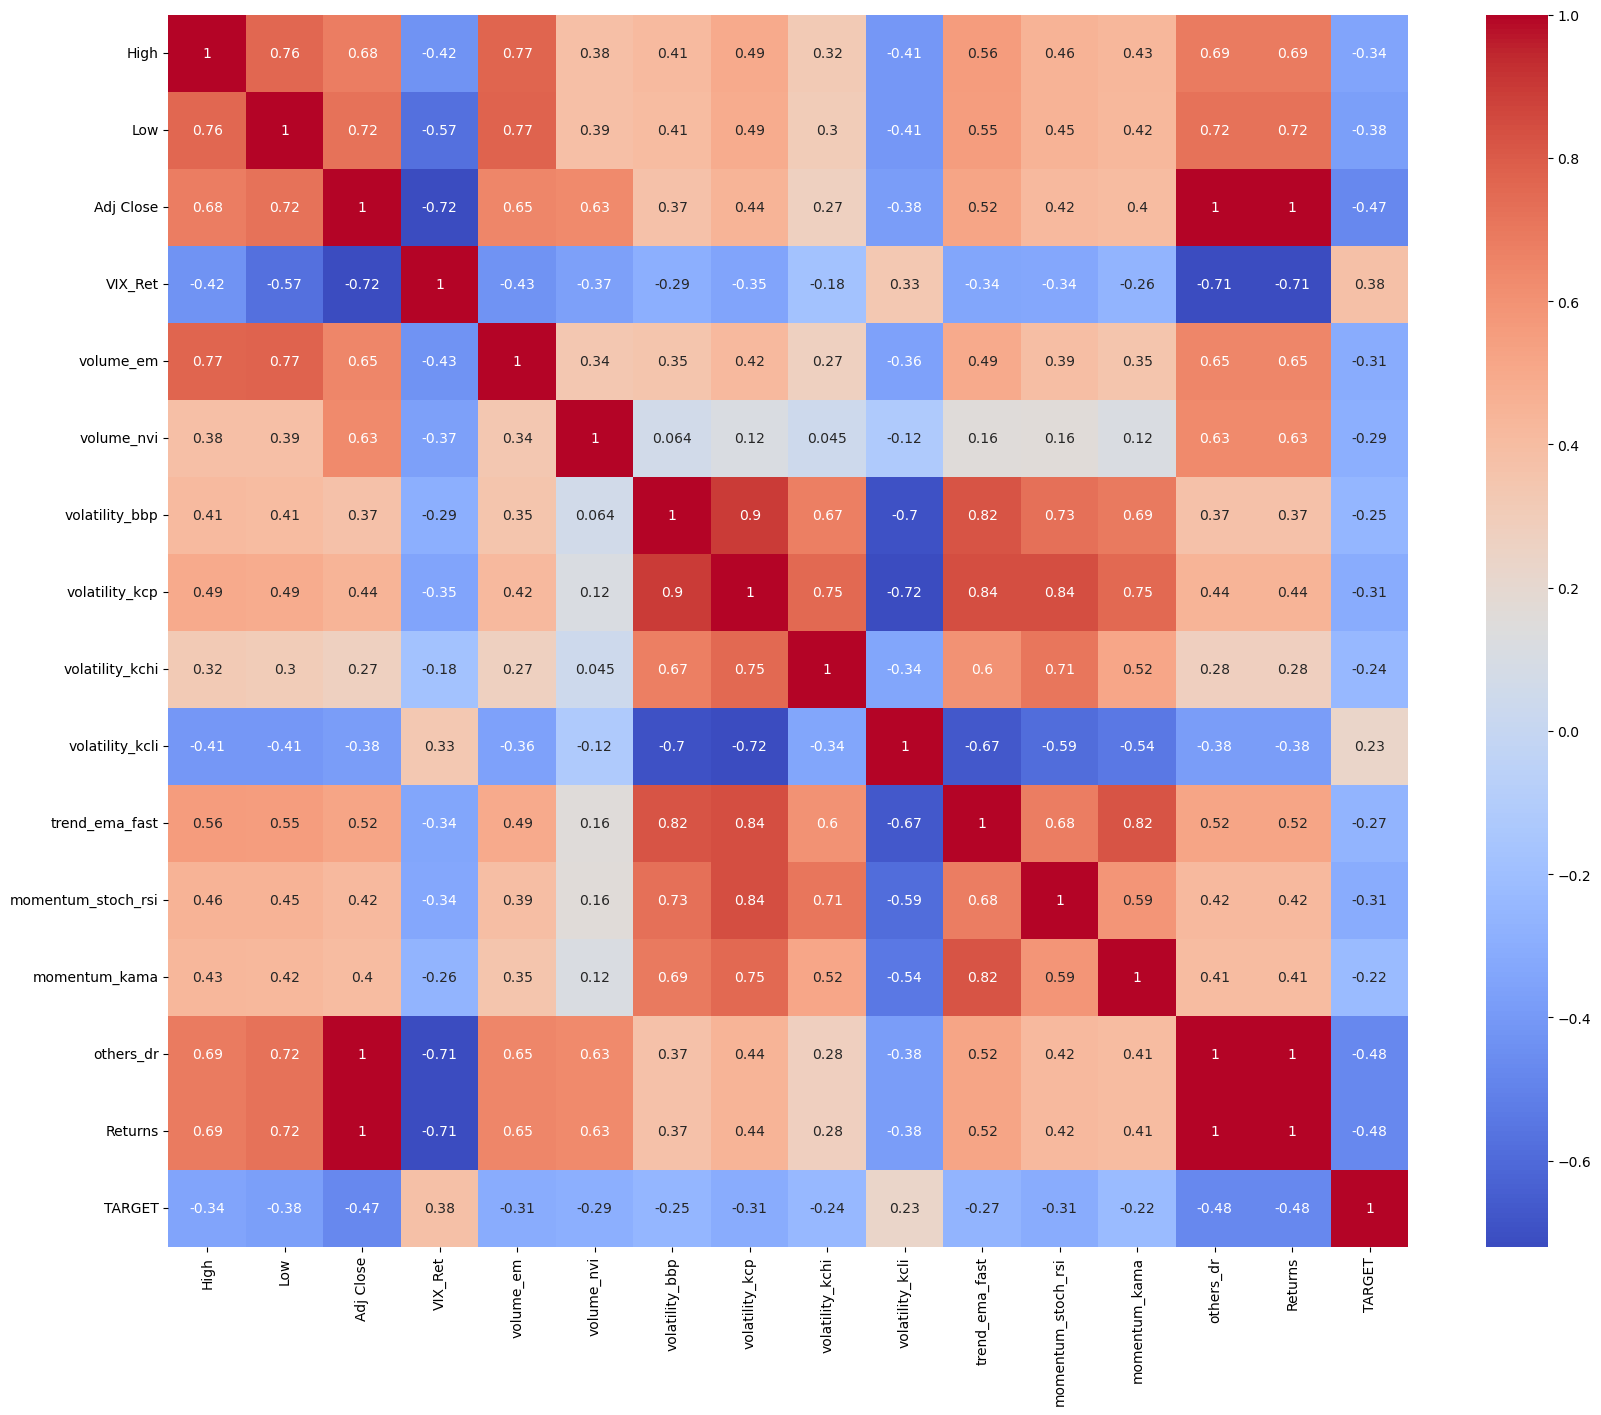

In [23]:
# Plot Heatmap
# Calculate the correlation matrix
corr_matrix = df_sc.corr()

# Create a heatmap
plt.figure(figsize=(20,16))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')

# Show the plot
plt.show()

In [24]:
# DataFrame Info
df_sc.info()

# Describe DataFrame
df_sc.describe()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2484 entries, 2014-09-17 to 2024-08-02
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   High                2484 non-null   float64
 1   Low                 2484 non-null   float64
 2   Adj Close           2484 non-null   float64
 3   VIX_Ret             2484 non-null   float64
 4   volume_em           2484 non-null   float64
 5   volume_nvi          2484 non-null   float64
 6   volatility_bbp      2484 non-null   float64
 7   volatility_kcp      2484 non-null   float64
 8   volatility_kchi     2484 non-null   float64
 9   volatility_kcli     2484 non-null   float64
 10  trend_ema_fast      2484 non-null   float64
 11  momentum_stoch_rsi  2484 non-null   float64
 12  momentum_kama       2484 non-null   float64
 13  others_dr           2484 non-null   float64
 14  Returns             2484 non-null   float64
 15  TARGET              2484 non-null   i

,High,Low,Adj Close,VIX_Ret,volume_em,volume_nvi,volatility_bbp,volatility_kcp,volatility_kchi,volatility_kcli,trend_ema_fast,momentum_stoch_rsi,momentum_kama,others_dr,Returns,TARGET
count,2484.000000,2484.000000,2484.000000,2484.000000,2484.000000,2484.000000,2484.000000,2484.000000,2484.000000,2484.000000,2484.000000,2484.000000,2484.000000,2484.000000,2484.000000,2484.000000
mean,0.000435,0.000446,0.000527,0.003474,0.497864,0.001360,0.600099,0.684665,0.365539,0.164654,0.000409,0.563167,0.000412,0.045634,0.000456,0.483897
std,0.008790,0.010184,0.011126,0.084197,18.156228,0.006902,0.326162,0.681950,0.481678,0.370942,0.002936,0.358849,0.003239,1.117465,0.011175,0.499841
min,-0.060498,-0.085647,-0.109424,-0.259057,-145.736230,-0.109424,-0.473078,-1.894459,0.000000,0.000000,-0.025672,0.000000,-0.030433,-10.942374,-0.109424,0.000000
25%,-0.003102,-0.003961,-0.003730,-0.043442,-3.250662,0.000000,0.363654,0.247604,0.000000,0.000000,-0.000730,0.242150,-0.000125,-0.385266,-0.003853,0.000000
50%,0.000735,0.000899,0.000596,-0.007044,0.454432,0.000000,0.688889,0.733978,0.000000,0.000000,0.000870,0.609046,0.000148,0.056978,0.000570,0.000000
75%,0.004564,0.005678,0.005918,0.036511,4.749453,0.001858,0.858976,1.172545,1.000000,0.000000,0.002101,0.923020,0.001373,0.591501,0.005915,1.000000
max,0.062783,0.071200,0.090603,1.155979,107.743910,0.090603,1.252445,2.479098,1.000000,1.000000,0.011564,1.000000,0.018970,9.060326,0.090603,1.000000


In [25]:
# Train Test Split
df_tts = df_sc.copy()

In [26]:
# Split into X and y data
X = df_tts.iloc[:, : -1]
y = df_tts.iloc[:, -1]

# Perform Train Test Split (Timeseries based method)
train_size_rate = 0.7
train_size = int(len(X) * train_size_rate)
test_size = len(X) - train_size

X_train = X.head(train_size)
y_train = y.head(train_size)
X_test = X.tail(test_size)
y_test = y.tail(test_size)

size_check = len(y_test) + len(y_train) == len(X)
print("Shape of X_train: ", X_train.shape)
print("Shape of y_train: ", y_train.shape)
print("Shape of X_test: ", X_test.shape)
print("Shape of y_test: ", y_test.shape)
print("Size Matches: ", size_check)

Shape of X_train:  (1738, 15)
Shape of y_train:  (1738,)
Shape of X_test:  (746, 15)
Shape of y_test:  (746,)
Size Matches:  True


## Build Model

In [27]:
# Select type of model to optimize for
is_binary = True
is_optimise_for_precision = True

# Determine Objective and Eval Metrics
if is_binary:
    objective = "binary:logistic"
    eval_metric = "logloss"
    eval_metric_list = ["error", "logloss", eval_metric]
else:
    objective = "multi:softmax"
    eval_metric = "mlogloss"
    eval_metric_list = ["merror", "mlogloss", eval_metric]

# Refine Eval Metric
if is_binary and is_optimise_for_precision:
    eval_metric = "aucpr"
    scoring = "precision"
elif is_binary and not is_optimise_for_precision:
    eval_metric = "auc"
    scoring = "f1"
else:
    scoring = "accuracy"

In [28]:
ne = 100
lr = 0.05
md = 3
gm = 12

# XGBOOST Classifier
classifier = XGBClassifier(
    objective=objective,
    booster="gbtree",
    eval_metric=eval_metric,
    n_estimators=ne,
    learning_rate=lr,
    max_depth=md,
    gamma=gm,
    reg_alpha=1,
    subsample=0.8,
    colsample_bytree=1,
    random_state=42,
    use_label_encoder=False,
)

In [29]:
# Fit Model
eval_set = [(X_train, y_train), (X_test, y_test)]
classifier.set_params(eval_metric=['logloss', 'error'])
classifier.fit(X_train, y_train, eval_set=eval_set, verbose=False)

XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None, colsample_bytree=1,
              device=None, early_stopping_rounds=None, enable_categorical=False,
              eval_metric=['logloss', 'error'], feature_types=None, gamma=12,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [30]:
# Make Predictions
train_yhat = classifier.predict(X_train)
train_yhat_proba = classifier.predict_proba(X_train)
print("Preds Training Data: \n", train_yhat[:10])
print("Preds Probabilities Training Data: \n", train_yhat_proba[:10])

Preds Training Data: 
 [0 0 1 1 1 0 1 0 1 1]
Preds Probabilities Training Data: 
 [[0.60375434 0.39624566]
 [0.75804406 0.24195592]
 [0.22976625 0.77023375]
 [0.16906953 0.8309305 ]
 [0.1835435  0.8164565 ]
 [0.8008166  0.1991834 ]
 [0.16906953 0.8309305 ]
 [0.786746   0.21325397]
 [0.31743085 0.68256915]
 [0.27807027 0.7219297 ]]


In [31]:
# Get Predictions Test
test_yhat = classifier.predict(X_test)
test_yhat_proba = classifier.predict_proba(X_test)
print("Preds Test Data: \n", test_yhat[:10])
print("Preds Probabilities Training Data: \n", test_yhat_proba[:10])

Preds Test Data: 
 [0 1 1 0 0 0 0 0 1 0]
Preds Probabilities Training Data: 
 [[0.6454916  0.35450837]
 [0.17867368 0.8213263 ]
 [0.1835435  0.8164565 ]
 [0.5139389  0.48606113]
 [0.8402114  0.1597886 ]
 [0.84319985 0.15680018]
 [0.59262264 0.4073774 ]
 [0.63314986 0.36685014]
 [0.18198901 0.818011  ]
 [0.82920796 0.17079206]]


In [32]:
# Set K-Fold Cross Validation Levels
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=1, random_state=42)

# Training Results
train_results = cross_val_score(classifier, X_train, y_train, scoring=scoring, cv=cv, n_jobs=1)

This is a cross-validation strategy used to evaluate the performance of a model. It's specifically designed for classification problems to ensure that each fold maintains the same proportion of classes as the original dataset.  The dataset is divided into 5 folds. In each iteration, 4 folds are used for training and 1 fold is used for testing.

In [33]:
# Evaluation Metrics
results = classifier.evals_result()
epochs = len(results['validation_0']['error'])
x_axis = range(0, epochs)

This function is used to obtain evaluation metrics collected during the training of the classifier.  By checking the length of the error metrics list for the validation set, it determines the number of epochs that the model was trained for.

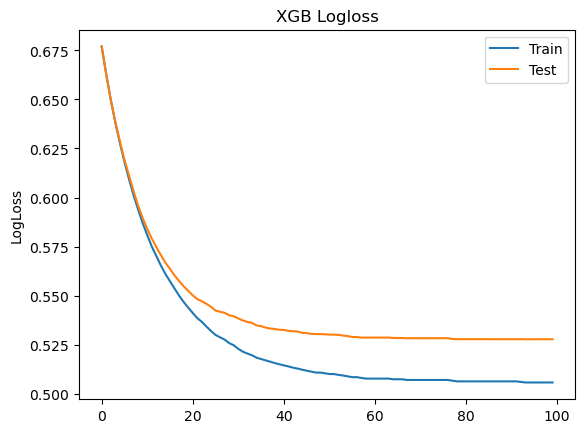

In [34]:
# Plot Log Loss
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['logloss'], label='Train')
ax.plot(x_axis, results['validation_1']['logloss'], label='Test')
ax.legend()
plt.ylabel('LogLoss')
plt.title('XGB Logloss')
plt.show()

The Log Loss for both the train and test sets decrease over epochs, indicating that the model is learning and improving.  Training and test Log Loss converge towards a stable value indicating that the model is training correctly.  There is no significant divergence, where training Log Loss continues to decrease while test Log Loss starts to increase, that might indicate overfitting.

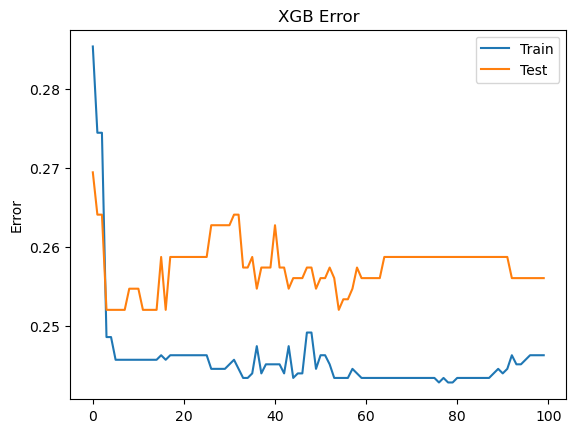

In [35]:
# Plot Classification Error
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['error'], label='Train')
ax.plot(x_axis, results['validation_1']['error'], label='Test')
ax.legend()
plt.ylabel('Error')
plt.title('XGB Error')
plt.show()

The training and testing error both show a decreasing trend then fluctuate before smoothing out ~60 epochs.  There is a slight increase in the training data error rate ~90 epochs which could potentially indicate overfitting, but it is not definitive on its own.  Overfitting usually manifests as a decreasing training error while the test error starts to increase.  Sometimes, a sudden increase in training error can be due to a learning rate that is too high, causing the model to oscillate or diverge slightly. This can result in temporary increases in training error even if the model is generally learning.

In [36]:
# Compute ROC curve and ROC area for each class
fpr_train, tpr_train, _ = roc_curve(y_train, train_yhat)
roc_auc = auc(fpr_train, tpr_train)

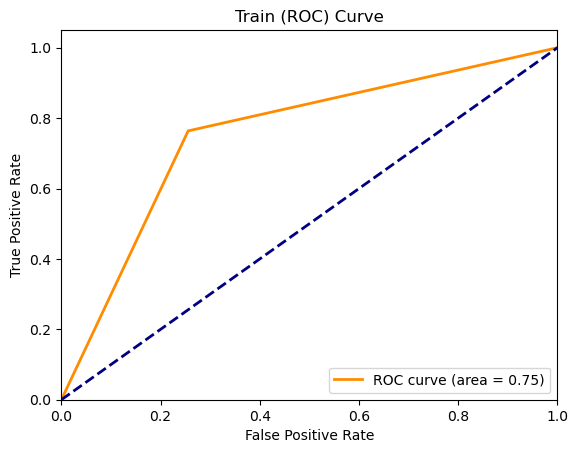

In [37]:
# Plot ROC curve
plt.figure()
plt.plot(fpr_train, tpr_train, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Train (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [38]:
# Compute ROC curve and ROC area for each class
fpr_test, tpr_test, _ = roc_curve(y_test, test_yhat)
roc_auc = auc(fpr_test, tpr_test)

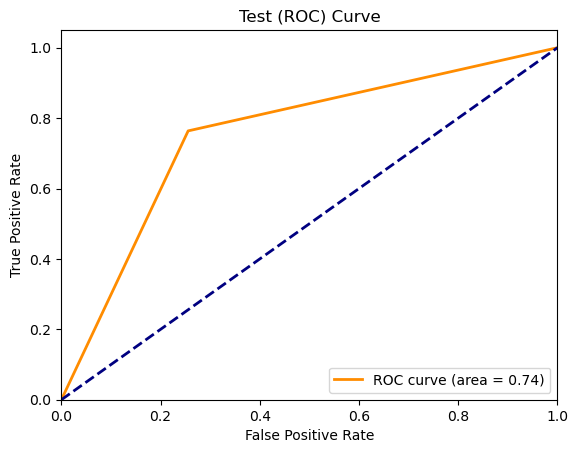

In [39]:
# Plot ROC curve
plt.figure()
plt.plot(fpr_train, tpr_train, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Test (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [40]:
# Testing Results
test_results = cross_val_score(classifier, X_test, y_test, scoring=scoring, cv=cv, n_jobs=-1)

In [41]:
# Comparison of Results
print("TRAIN:")
print("Average Acc K-Fold", round(train_results.mean(), 2))
print("Std Dev K-Fold", round(train_results.std(), 2))
print("Precision Score 0", round(precision_score(y_train, train_yhat, average=None)[0], 3))
print("Precision Score 1", round(precision_score(y_train, train_yhat, average=None)[1], 3))
print("----- ----- ----- ----- ----- ----- -----")
print("TEST:")
print("Average Acc K-Fold", round(test_results.mean(), 2))
print("Std Dev K-Fold", round(test_results.std(), 2))
print("Precision Score 0", round(precision_score(y_test, test_yhat, average=None)[0], 3))
print("Precision Score 1", round(precision_score(y_test, test_yhat, average=None)[1], 3))
print("")

TRAIN:
Average Acc K-Fold 0.73
Std Dev K-Fold 0.01
Precision Score 0 0.772
Precision Score 1 0.736
----- ----- ----- ----- ----- ----- -----
TEST:
Average Acc K-Fold 0.75
Std Dev K-Fold 0.03
Precision Score 0 0.765
Precision Score 1 0.725



General Performance: The model performs slightly better on the test data than on the training data, which is a good sign of generalization and not overfitting.

Consistency: The low standard deviation for training accuracy and the relatively low standard deviation for test accuracy indicate consistent performance across different folds.

Precision: Precision scores for both classes are slightly lower on the test set compared to the training set, which is common. The precision for class 0 is generally better than for class 1, which may suggest that class 0 is more easily distinguishable by the model.

Overall, the model shows good performance and generalization capabilities, with only minor differences in precision and accuracy between the training and test sets.

In [42]:
# Show summary report - Training
print(classification_report(y_train, train_yhat))

              precision    recall  f1-score   support

           0       0.77      0.74      0.76       900
           1       0.74      0.76      0.75       838

    accuracy                           0.75      1738
   macro avg       0.75      0.75      0.75      1738
weighted avg       0.75      0.75      0.75      1738



Training Performance: The model's precision and recall scores are relatively high and balanced across both classes. The F1-scores are close to 0.75, indicating a good balance between precision and recall. The accuracy of 73% suggests that the model performs well on the training data.

Cross-Validation: The average accuracy from cross-validation is consistent with the overall training accuracy, and the low standard deviation indicates that the model's performance is stable across different subsets of the training data.

Overall, the training metrics indicate that the model performs effectively, with balanced precision and recall across classes. The consistent cross-validation results suggest that the model is robust and not overly dependent on any particular subset of the training data.

In [43]:
# Show summary report - Test
print(classification_report(y_test, test_yhat))

              precision    recall  f1-score   support

           0       0.76      0.72      0.74       382
           1       0.72      0.77      0.74       364

    accuracy                           0.74       746
   macro avg       0.74      0.74      0.74       746
weighted avg       0.75      0.74      0.74       746



Test Performance: The model shows similar performance on the test data as it did on the training data. The precision, recall, and F1-scores are closely aligned across both classes and are balanced overall.

Accuracy: The accuracy of 74% is close to the training accuracy of 73%, indicating that the model generalizes well to unseen data.

Balance: The test metrics reflect a balanced performance, with no significant drop in performance compared to the training metrics.
Comparison with Training Data

Precision: Slightly lower for class 1 in the test set compared to the training set.

Recall: Slightly lower for class 0 in the test set compared to the training set.

F1-Score: Consistent across training and test sets, showing balanced precision and recall.

Overall, these results suggest that the model performs consistently across training and test data, indicating that it is not overfitting and generalizes well.

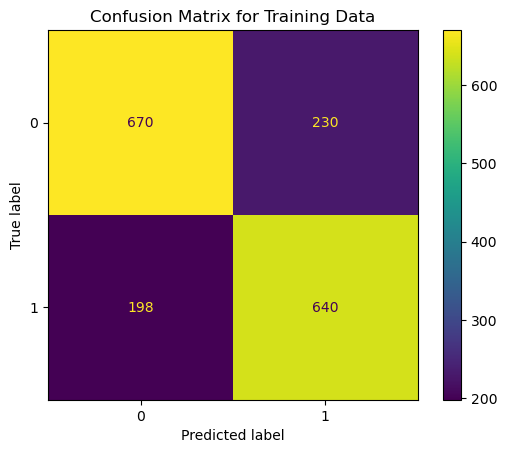

In [47]:
# Training Confusion Matrix
cm_train = confusion_matrix(y_train, train_yhat)
ConfusionMatrixDisplay(cm_train).plot()
plt.title('Confusion Matrix for Training Data')
plt.show()


Model Bias: The model seems to be slightly better at predicting stock increases (with higher recall for class 1) but slightly less precise (lower precision for class 1) than for decreases.

Business Implication:

False Positives (230 instances) can be particularly costly if a stock is predicted to increase and it actually decreases. Investors may buy stock based on incorrect predictions, leading to potential losses.
False Negatives (198 instances) might result in missed opportunities where the model predicts a decrease and the stock actually increases, leading to potential missed profits.

Model Reliability:

The model has a balanced accuracy and shows a fair trade-off between precision and recall for both classes. However, there is room for improvement, especially in reducing the number of false positives, which would be crucial in financial decision-making.

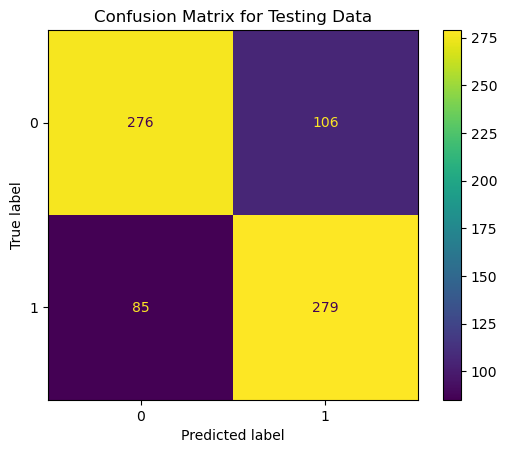

In [48]:
# Test Confusion Matrix
cm_test = confusion_matrix(y_test, test_yhat)
ConfusionMatrixDisplay(cm_test).plot()
plt.title('Confusion Matrix for Testing Data')
plt.show()

Model Bias: The model's precision and recall for classifying increases are slightly lower compared to classifying decreases, indicating a small bias towards predicting decreases more accurately.

Business Implication:

False Positives (106 instances) remain a critical issue. If a stock is incorrectly predicted to increase, and it actually decreases, this could lead to potential financial losses due to poor investment decisions.
False Negatives (85 instances) are also significant, as they represent missed opportunities where the model predicted a decrease when the stock actually increased.

Model Reliability:

The model maintains a balanced accuracy on the test data and has comparable performance to the training data, indicating that it has generalized fairly well. However, the number of false positives is still a concern, especially in financial contexts where prediction accuracy is paramount.

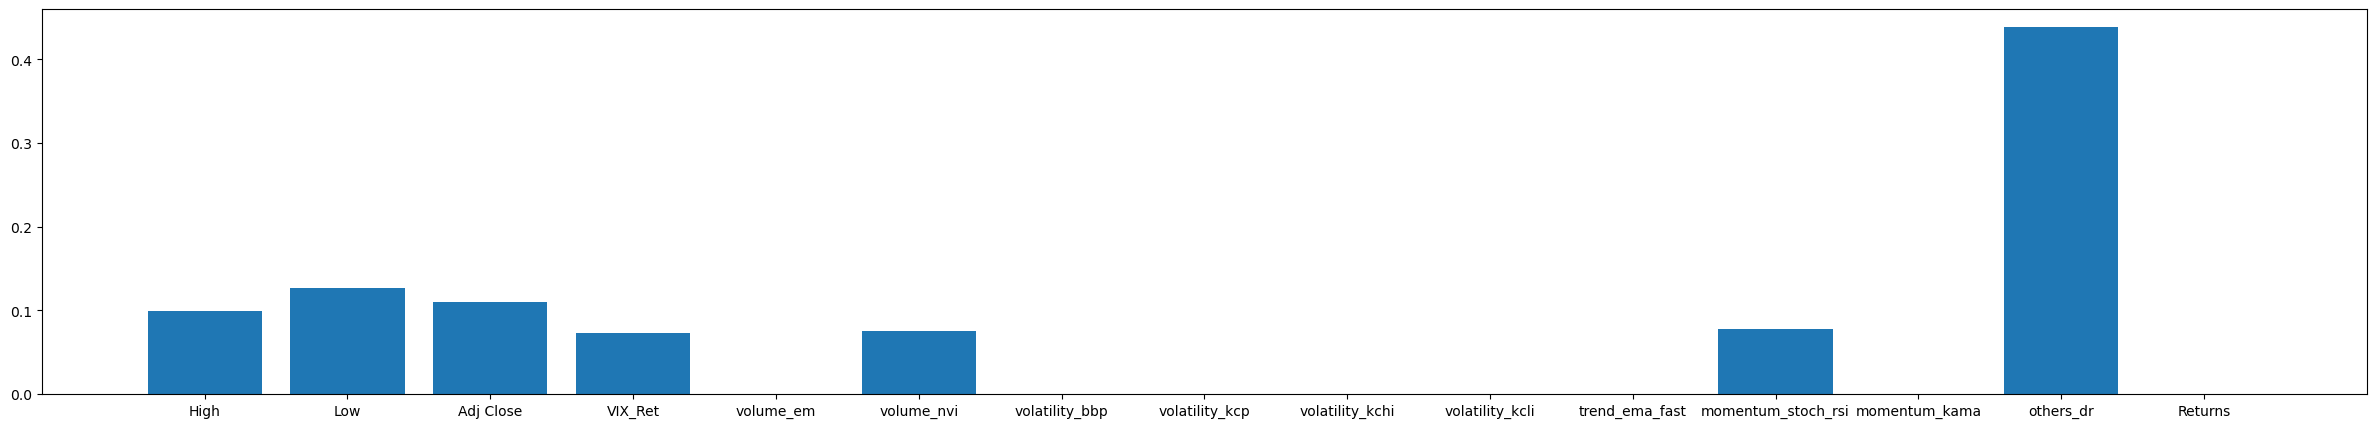

In [46]:
# Plot Feature Importances
fig = plt.figure(figsize=(30, 5))
importance_labels = X.columns
importance_features = classifier.feature_importances_
plt.bar(importance_labels, importance_features)
plt.show()

This feature importance analysis reveals that the model heavily relies on a feature labeled others_dr, suggesting it encapsulates crucial predictive information for stock returns. Traditional stock metrics, like price and volume, still hold value, but other common technical indicators such as volatility and momentum are less influential in this context. Understanding the nature of others_dr could further enhance the model’s interpretability and predictive power.